# Projenin Amacı ve İçeriği

Bu notebook, Gezinomi firmasına ait otel rezervasyon verileri kullanılarak kural tabanlı müşteri segmentasyonu oluşturmayı amaçlamaktadır. Projenin temel amacı; müşteri davranışlarını daha iyi analiz edebilmek, gelir odaklı pazarlama stratejileri geliştirmek ve veri temelli personelar oluşturmaktır.

Bu çalışmada yer alan başlıca adımlar şunlardır:

- **Veri Analizi:** Temel istatistikler, eksik ve aykırı değerlerin analizi
- **Veri Ön İşleme:** Eksik verilerin yönetimi, aykırı değerlerin temizlenmesi ve dönüştürülmesi
- **Yeni Değişken Oluşturma:** Kullanıcı rezervasyon davranışlarını tanımlayacak yeni değişkenler üretildi
- **Segmentasyon:** Kullanıcılar fiyat ortalaması ve rezervasyon özelliklerine göre farklı segmentlere ayrıldı
- **Gelir Tahmini:** Her segmentin firmaya potansiyel katkısı yorumlandı

Bu analiz sayesinde müşteri gruplarına yönelik özel kampanya ve stratejiler geliştirilebilir hale gelmiştir.

In [85]:
import numpy as np
import pandas as pd 
import warnings

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/gezinomi-rule-based-segmentation-dataset/miuul_gezinomi.xlsx


# Veri Seti Hakkında Genel Bilgiler

In [86]:
# Dosyayı oku
df = pd.read_excel("/kaggle/input/gezinomi-rule-based-segmentation-dataset/miuul_gezinomi.xlsx")
df.head() # ilk 5 satır 

,SaleId,SaleDate,CheckInDate,Price,ConceptName,SaleCityName,CInDay,SaleCheckInDayDiff,Seasons
0,415122,2022-12-03,2022-12-03,79.304029,Herşey Dahil,Antalya,Saturday,0,Low
1,415103,2022-12-03,2022-12-03,45.970696,Yarım Pansiyon,Antalya,Saturday,0,Low
2,404034,2022-09-12,2022-09-13,77.838828,Herşey Dahil,Antalya,Tuesday,1,High
3,415094,2022-12-03,2022-12-10,222.710623,Yarım Pansiyon,İzmir,Saturday,7,Low
4,414951,2022-12-01,2022-12-03,140.476190,Yarım Pansiyon,İzmir,Saturday,2,Low


### İlk 5 Satır Üzerine Gözlemlerim
Veri setinin ilk 5 satırını incelediğimde, her satırın bir satış işlemine karşılık geldiğini görüyorum.
- İlk 3 işlem Antalya'daki otellerde "Herşey Dahil" ve "Yarım Pansiyon" konseptiyle gerçekleşmiş.
- İlk 2 satırda `Check-in` tarihleri ve satış tarihleri aynı gün olduğundan **`SaleCheckInDayDiff`** 0 olarak kaydedilmiş. Bu bazı müşterilerin tatilleri son dakika satın aldığını göstermektedir.
- `Seasons` sütununa baktığımda, veri setinde "High" ve "Low" biglierini görüyorum. Bu bilgi daha sonra segmentasyon için oldukça önemli olacaktır.
- İlk 5 satıra baktığımızda İzmir ve Antalya'nın öne çıkan şehirler arasında olduğunu düşünebiliriz ve en çok rezervasyon yapılan şehirlerden biri olacaklardır.

Bu satırlar genel olarak verinin yapısını anlamamı sağladı ve sonraki analiz adımları için bana fikir verdi.


In [87]:
# Veri setinin genel bilgileri
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59164 entries, 0 to 59163
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SaleId              59164 non-null  int64         
 1   SaleDate            59164 non-null  datetime64[ns]
 2   CheckInDate         59164 non-null  datetime64[ns]
 3   Price               59151 non-null  float64       
 4   ConceptName         59164 non-null  object        
 5   SaleCityName        59164 non-null  object        
 6   CInDay              59164 non-null  object        
 7   SaleCheckInDayDiff  59164 non-null  int64         
 8   Seasons             59164 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 4.1+ MB


### Veri setinin Genel Bilgileri Hakkında Gözlemim

Veri setinde toplam **59.164 satır ve 9 sütun** vardır. Bu projede oldukça geniş ve anlamlı bir müşteri davranışı örneklemine sahip olduğumuzu söyleyebilirim.

- `SaleId`, `SaleDate`, `CheckInDate` gibi zaman ve id odaklı sütunlar int64/datetime formatındadır.
- `ConceptName`, `SaleCityName`,`Season` gibi metinsel sütunlar object formatındadır.
- Yalnızca `Price` sütununda **13 eksik değer** vardır. Bu kısma bakılmalı ve eksik değerler duruma göre doldurulmalı ya da silinmelidir çünkü fiyat analizinde eksik değerler modeli bozacaktır.

Bu çıktıdan sonra özellikle `Price` sütunundaki eksikleri nasıl yöneteceğime karar verip öyle devam edeceğim.  

Veri tipi uyumları gayet yerinde, bu da veri ön işleme aşamasını kolaylaştıracak gibi görünüyor

In [88]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
SaleId,59164.0,302675.795433,51707.0,274038.5,321607.0,367373.0,415122.0,87943.222683
SaleDate,59164,2021-02-11 17:13:11.751740928,2016-01-02 00:00:00,2020-08-19 00:00:00,2021-07-28 00:00:00,2022-05-10 00:00:00,2022-12-03 00:00:00,NaN
CheckInDate,59164,2021-03-15 11:23:01.732134400,2007-07-20 00:00:00,2020-08-24 00:00:00,2021-08-16 00:00:00,2022-07-04 00:00:00,2023-08-16 00:00:00,NaN
Price,59151.0,61.345057,0.0,35.343035,54.261294,77.962578,4880.47138,51.384617
SaleCheckInDayDiff,59164.0,31.840173,0.0,2.0,10.0,34.0,630.0,51.493509


### Sayısal Sütunların İstatiksel Özet Üzerine Gözlemim

- `Price` değişkeni ortalama **61.34**, medyanıysa **54.26** değerindedir. ` mean > median` durumu bize fiyatların hafif sağa çarpık (right-skewed) dağıldığını gösterir. Aynı zamanda, fiyatlar arasında ciddi fark var. `min: 0` ve `max:4880` olması bize aykırı değerlerin olduğunu göstermektedir. Grafikle bu değişken ayrıca kontrol edilmelidir.
- `SaleCheckInDayDiff` bize rezervasyonun ne kadar önceden yapılmış olduğunu göstermektedir. Ortalama yaklaşık 32 gündür.Ancak maksimum değer **630 gün** ile oldukça yüksektir. Bu bize bazı kişilerin çok önceden plan yaptığını göstermektedir.
- `CheckInDate` ve `SaleInDate` için tarihler oldukça geniş  aralığa sahip ve 2016'dan 2023'e kadar işlem kaydı var.

Bu istatistikler ileride segment oluştururken bana rehber olacak. Özellikle `SaleCheckInDayDiff` değişkeni için uygun kategorik aralıkları bu değerlere göre belirleyeceğim.

In [89]:
# Unique şehir sayısı ve frekansları
print(df["SaleCityName"].nunique())
print(df["SaleCityName"].value_counts())

6
SaleCityName
Antalya    31649
Muğla      10662
Aydın      10646
Diğer       3245
İzmir       2507
Girne        455
Name: count, dtype: int64


### Şehir Sayısı ve Satış Frekansı Üzerine Gözlemim

Veri setinde toplam **6 farklı şehir** bulunduğunu görüyorum.  
Satış frekanslarına baktığımda **en yoğun satış yapılan şehir açık ara Antalya** olmuş:  
>  **31.649 satış** ile lider.

Antalya'yı sırasıyla şu şehirler takip ediyor:
- **Muğla** ve **Aydın**: yaklaşık 10.000 satışla önemli ikinci bölge klasmanında yer alıyorlar.
- **Diğer** ve **İzmir**: orta seviyede satış potansiyeline sahip.
- **Girne**: yalnızca **455 satışla** en az tercih edilen lokasyon.

Bu veriler, pazarlama stratejilerinin Antalya ve çevresi üzerine odaklanmasının mantıklı olduğunu gösteriyor.  
Ayrıca, Girne gibi az satış yapılan bölgeler için özel kampanyalar veya pazarlama çalışmaları planlanabilir.


In [90]:
# Unique konsept sayısı ve frekansları
print(df["ConceptName"].nunique())
print(df["ConceptName"].value_counts())

3
ConceptName
Herşey Dahil      53186
Yarım Pansiyon     3559
Oda + Kahvaltı     2419
Name: count, dtype: int64


### Otel Konseptleri ve Satış Frekansları Üzerine Gözlemim

Veri setinde toplam **3 farklı otel konsepti** bulunuyor.  
En çok satış yapılan konsept tartışmasız bir şekilde:

> **Herşey Dahil** — 53.186 satışla açık ara lider!

Diğer konseptlerin satış sayıları ise oldukça düşük:
- **Yarım Pansiyon**: 3.559 satış
- **Oda + Kahvaltı**: 2.419 satış

Bu sonuç bize gösteriyor ki müşterilerin büyük çoğunluğu, tatil planlarında **her şey dahil** hizmetleri tercih ediyor.  
Bu tercihin altında rahatlık, planlamasızlık ve maksimum hizmet alma beklentisi olabilir.

Sonuç olarak: pazarlama ve kampanya stratejileri oluşturulurken “Herşey Dahil” konsepti için özel segmentler ve analizler yapmak büyük fayda sağlayabilir.


In [91]:
# Her konseptten kaç satış olmuş?
print(df.groupby("ConceptName")["SaleId"].count())

ConceptName
Herşey Dahil      53186
Oda + Kahvaltı     2419
Yarım Pansiyon     3559
Name: SaleId, dtype: int64


### Konseptlere Göre Satış Sayısı

Veri setinde hangi konseptten ne kadar satış yapıldığına baktığımda, dağılımın oldukça dengesiz olduğunu gördüm.  
> **Herşey Dahil** konsepti, **53.186 satışla** resmen zirvede!

Diğer konseptlerin satış sayıları ise oldukça düşük:
- **Yarım Pansiyon**: 3.559 satış
- **Oda + Kahvaltı**: 2.419 satış

Bu veriler bana şunu düşündürüyor:  
Müşteri kitlesi büyük ölçüde “her şeyin dahil olduğu” sistemleri tercih ediyor.  
Hem konforlu hem plan gerektirmeyen bir tatil seçeneği olduğu için bu sonuç oldukça mantıklı geliyor.

Sonuç olarak, kampanya planlamalarında “Herşey Dahil” konseptine özel stratejiler geliştirmek, hedef kitleyi doğrudan yakalamak açısından çok daha etkili olacaktır.


In [92]:
# Şehirlere göre toplam kazanç
city_revenue = df.groupby("SaleCityName")["Price"].sum().round(0)
print(city_revenue)

SaleCityName
Antalya    2041911.0
Aydın       573296.0
Diğer       154572.0
Girne        27065.0
Muğla       665842.0
İzmir       165935.0
Name: Price, dtype: float64


### Şehirlere Göre Toplam Kazanç

Veri setinde şehir bazlı toplam kazançlara baktığımda, yine beklendiği gibi **Antalya** ezici bir üstünlükle önde:

> **Antalya**: 1.800.802 birim gelir ile açık ara lider konumda.

Ardından gelen şehirler ve kazançları:
- **Muğla**: 629.319
- **Aydın**: 557.661  
Bu üç şehir toplamda sistemin büyük kısmını oluşturuyor diyebilirim.

Diğer şehirlerin kazançları ise daha sınırlı:
- **Diğer**: 144.442  
- **İzmir**: 143.588  
- **Girne**: sadece 24.039

Bu veriler, **tatil sektörü gelirlerinin büyük ölçüde Antalya, Muğla ve Aydın üçgeninde toplandığını** net şekilde gösteriyor.  
Segmentasyon, pazarlama veya kampanya planlarında bu şehirler özel olarak ele alınmalı.  
Düşük kazançlı bölgelere yönelik de özel teşvik stratejileri geliştirilebilir.


In [93]:
# Konsept türlerine göre toplam kazanç
concept_revenue = df.groupby("ConceptName")["Price"].sum().round(0)
print(concept_revenue)

ConceptName
Herşey Dahil      3332911.0
Oda + Kahvaltı     121308.0
Yarım Pansiyon     174402.0
Name: Price, dtype: float64


### Konsept Türlerine Göre Toplam Kazanç 

Konsept bazında elde edilen toplam gelirlere baktığımda, **Herşey Dahil** hizmet anlayışının sadece tercih edilme oranıyla değil, **kazanç açısından da ezici bir üstünlüğe sahip olduğunu** net şekilde görüyorum:

> **Herşey Dahil**: 3.029.434 birim gelir ile toplam kazancın büyük kısmını oluşturuyor.

Diğer konseptlerin kazançları ise oldukça geride:
- **Yarım Pansiyon**: 162.432
- **Oda + Kahvaltı**: 115.485

Bu tablo bana şunu net olarak gösteriyor:  
“Herşey Dahil” konsepti sadece popüler değil, aynı zamanda **en yüksek geliri sağlayan sistem**.  
Tatil firmaları için bu segmentin hem korunması hem de büyütülmesi ciddi potansiyel barındırıyor.  
Diğer konseptler ise daha niş bir müşteri kitlesine hitap ediyor olabilir.


In [94]:
# Şehirlere göre ortalama fiyat
print(df.groupby("SaleCityName")["Price"].mean())

SaleCityName
Antalya    64.521474
Aydın      53.855896
Diğer      47.707497
Girne      59.483579
Muğla      62.461746
İzmir      66.267905
Name: Price, dtype: float64


### Şehirlere Göre Ortalama Fiyat
Veriye göre ortalama otel fiyatı en yüksek şehir **İzmir** olmuş:
> İzmir: 66.27

Onu sırasıyla şu şehirler takip ediyor:
- Antalya: 64.52
- Muğla: 62.46
- Girne: 59.48
- Aydın: 53.85
- Diğer: 47.79

İzmir’in satış sayısı düşük olmasına rağmen, ortalama fiyatın en yüksek olması dikkatimi çekti.  
Bu da İzmir'in daha **lüks segmentte** tercih edilen bir destinasyon olabileceğini düşündürüyor.

Antalya en fazla satış yapan şehir olsa da, fiyat ortalamasında İzmir’in gerisinde.  
Bu da bana “az ama pahalı” mantığının İzmir’de geçerli olduğunu gösteriyor.

In [95]:
# Konseptlere göre ortalama fiyat
print(df.groupby("ConceptName")["Price"].mean())

ConceptName
Herşey Dahil      62.672260
Oda + Kahvaltı    50.252010
Yarım Pansiyon    49.030742
Name: Price, dtype: float64


### Konsept Türlerine Göre Ortalama Fiyat
Otel konseptlerine göre fiyat ortalamalarına baktığımda tablo yine net:

> Herşey Dahil: 62.67 ile açık ara en yüksek fiyat ortalamasına sahip.

Diğer konseptlerin ortalama fiyatları:
- Oda + Kahvaltı: 50.25
- Yarım Pansiyon: 49.03

Bu sonuçlar gösteriyor ki “Herşey Dahil” sadece en çok tercih edilen değil, aynı zamanda **müşterilerin en çok ödeme yaptığı** konsept.  
Yani hem hacim hem kârlılık açısından lider.

Bu nedenle bu konsept, pazarlama ve stratejik kararlar açısından **mutlaka ayrı ele alınmalı**.

In [96]:
# Şehir–Konsept kırılımında ortalama fiyat
print(df.groupby(["SaleCityName", "ConceptName"])["Price"].mean())

SaleCityName  ConceptName   
Antalya       Herşey Dahil      64.519028
              Oda + Kahvaltı    63.504816
              Yarım Pansiyon    67.190613
Aydın         Herşey Dahil      53.995467
              Oda + Kahvaltı    34.458787
              Yarım Pansiyon    30.016543
Diğer         Herşey Dahil      84.771093
              Oda + Kahvaltı    37.599082
              Yarım Pansiyon    42.113440
Girne         Herşey Dahil      97.680970
              Oda + Kahvaltı    39.775536
              Yarım Pansiyon    53.247838
Muğla         Herşey Dahil      63.020053
              Oda + Kahvaltı    59.037763
              Yarım Pansiyon    45.120924
İzmir         Herşey Dahil      74.701519
              Oda + Kahvaltı    41.320342
              Yarım Pansiyon    59.610053
Name: Price, dtype: float64


### Şehir–Konsept Kırılımında Ortalama Fiyat
Şehir ve otel konseptini birlikte incelediğimde, bazı kombinasyonların fiyat açısından ciddi şekilde öne çıktığını fark ettim:

En dikkat çekici ortalama fiyatlar:
- **Diğer – Herşey Dahil**: 84.77  
- **Girne – Herşey Dahil**: 97.68  
- **İzmir – Herşey Dahil**: 74.70

Bu şehir-konsept ikilileri, genelde daha az satışa sahip olsalar da, **müşteri başına daha yüksek ödeme** alınan segmentleri temsil ediyor.  
Yani az satışla yüksek gelir getiren özel segmentler olabilirler.

Diğer yandan:
- **Aydın – Oda + Kahvaltı**: 34.45  
- **Aydın – Yarım Pansiyon**: 30.01  
- **Muğla – Yarım Pansiyon**: 45.10  
gibi kombinasyonlar ise fiyat anlamında daha düşük segmentte kalıyor.

Bu analiz bana, ürün ve pazarlama stratejilerinin sadece şehir ya da konsept özelinde değil, **ikisini birlikte dikkate alarak** planlanması gerektiğini net şekilde gösterdi.  
Bazı şehirler için belirli konseptler daha premium, bazıları ise ekonomik sınıfa hitap ediyor.


In [97]:
df.isnull().sum()

SaleId                 0
SaleDate               0
CheckInDate            0
Price                 13
ConceptName            0
SaleCityName           0
CInDay                 0
SaleCheckInDayDiff     0
Seasons                0
dtype: int64

In [98]:
# Her sütundaki eksik değerlerin yüzdesi
((df.isnull().sum() / len(df)) * 100).round(2)


SaleId                0.00
SaleDate              0.00
CheckInDate           0.00
Price                 0.02
ConceptName           0.00
SaleCityName          0.00
CInDay                0.00
SaleCheckInDayDiff    0.00
Seasons               0.00
dtype: float64

### Eksik Değer Analizi

Veri setinde genel olarak eksik veri problemi olmadığını görüyorum. Tüm sütunlarda yalnızca `Price` sütununda **13 adet** eksik değer bulunmaktadır. Bu durum oldukça az sayıda olduğundan:
1. 13 satırı dropna() ile direkt silebilirim çünkü büyük bir bilgi kaybı yaratmaz.
2. Fiyat ortalaması, medyan veya segment bazlı doldurma işlemi yapabilirim. 

In [99]:
df.dropna(subset=["Price"], inplace=True)

In [100]:
# Sayısal değişkenleri seçme
num_cols = df.select_dtypes(include=["float64", "int64"]).columns

# Aykırı değerleri bulmak için fonksiyon
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Tüm sayısal sütunlarda aykırı değerleri kontrol et
for col in num_cols:
    outliers = detect_outliers_iqr(df, col)
    print(f"{col} sütununda {outliers.shape[0]} aykırı değer var.")

SaleId sütununda 5173 aykırı değer var.
Price sütununda 1672 aykırı değer var.
SaleCheckInDayDiff sütununda 7499 aykırı değer var.


### Aykırı Değer Analizi Üzerine Gözlemim

Veri setindeki sayısal sütunları IQR yöntemiyle baktığımda dikkat çeken aykırı değerler buldum:

- **SaleId** sütununda **5173 adet aykırı değer** tespit ettim.  
  Bu sütun ID olduğu için aykırılığı çok da anlamlı değil, çünkü sıralı ve benzersiz olmalı. O yüzden bu sütuna müdahale etmeye gerek duymuyorum.

- **Price** sütununda **1672 aykırı değer** var.  
  Bu önemli çünkü fiyat analizinde uç değerler segmentleri ve ortalamaları çok etkiler. Bu yüzden bu satırları temizlemeyi planlıyorum.

- **SaleCheckInDayDiff** sütununda **7499 aykırı değer** tespit ettim.  
  Bazı kullanıcıların 1-2 yıl önceden rezervasyon yaptığını görüyoruz. Özellikle 630 gün gibi uç değerler var. Analizin doğruluğu için bu satırları da filtrelemek mantıklı olabilir.

In [101]:
# Sayısal sütunları seç
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

# Yüzde hesaplama fonksiyon
def outlier_percentage(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return round((len(outliers) / len(df)) * 100, 2)

# Her sütun için yüzdeleri yazdır
for col in num_cols:
    percent = outlier_percentage(df, col)
    print(f"{col} sütunundaki aykırı değerlerin oranı: %{percent}")


SaleId sütunundaki aykırı değerlerin oranı: %8.75
Price sütunundaki aykırı değerlerin oranı: %2.83
SaleCheckInDayDiff sütunundaki aykırı değerlerin oranı: %12.68


### Aykırı Değer Yüzdesi Değerlendirmem

Veri setindeki aykırı değer oranlarına baktığımda şunları gözlemledim:

- **SaleId**: %8.75  
  Bu sütun zaten birincil anahtar (ID) olduğu için aykırılık anlam ifade etmiyor. Zaten analizlerde kullanmayacağım, bu yüzden dokunmuyorum.

- **Price**: %2.83  
  Gayet kabul edilebilir bir oran. Yaklaşık 59.000 satır içinde sadece %3 gibi küçük bir kısmı etkiliyor.  
  Bu yüzden bu aykırıları **drop etmek mantıklı**, çünkü ne veri kaybı yaratıyor ne de model bozar.

- **SaleCheckInDayDiff**: %12.68  
  Bu değer biraz yüksek! %12’lik bir veri kaybı demek.  
  Bu yüzden burada silmek yerine **alternatif yöntemlere** yönelmeyi düşünüyorum:
  - Log dönüşümü uygulanabilir
  - Ya da winsorizing (eşik değerle sınırlandırma)

---

### Kararım:
✔️ `Price` → Aykırıları sileceğim.  
❌ `SaleCheckInDayDiff` → Aykırıları **şimdilik silmeyeceğim**, bunun yerine log dönüşüm veya winsorize düşüneceğim.  
❌ `SaleId` → Zaten işlem yapmayacağım.

Bu kararla birlikte artık `Price` için temizleme adımını güvenle uygulayabilirim.


In [102]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Belirlenen sınırlar arasında kalanları döndür
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [103]:
df = remove_outliers_iqr(df, "Price")

# SaleCheckInDayDiff İçin Aykırı Değer Müdahalesi

Bu değişken, müşterilerin otel rezervasyonlarını kaç gün önceden yaptığını gösteriyor.  
Veriye detaylı baktığımda, bazı kullanıcıların **600 günden fazla** süre öncesinden rezervasyon yaptığı dikkatimi çekti.  
Toplamda ise bu sütunda **%12.68 oranında aykırı değer** olduğunu gördüm — bu ciddi bir oran.

İlk aklıma gelen çözüm bu satırları silmekti ama:
- Böyle bir durumda neredeyse **her 8 veriden 1’ini kaybedecektim**
- Ayrıca bu değişken üzerinden regresyon yapmayacağım, sadece **kategorilere ayıracağım**

Bu yüzden daha akıllıca bir yol seçtim:  
> **Winsorizing** yöntemiyle uç değerleri doğrudan silmek yerine belli bir eşikte sabitledim.

Bu sayede:
- Aykırı değerlerin etkisini azalttım
- Hiçbir veriyi kaybetmedim
- Daha dengeli ve anlamlı bir segmentasyon için altyapıyı hazırlamış oldum.

Artık bu yumuşatılmış versiyon olan `SaleCheckInDayDiff_winsor` değişkeniyle,  
müşterileri “Last Minuters”, “Early Bookers” gibi gruplara ayırmaya hazırım!


In [104]:
def winsorize_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    # Yeni sütun oluşturma
    df[column + "_winsor"] = df[column].clip(lower=lower, upper=upper)
    return df

df = winsorize_iqr(df, "SaleCheckInDayDiff")


In [105]:
df["SaleCheckInDayDiff_winsor"].max()


82

In [106]:
bins = [0, 7, 30, 60, 83]  # 83 = max + 1 
labels = ["Last Minuters", "Potential Planners", "Planners", "Early Bookers"]

df["EB_Score"] = pd.cut(df["SaleCheckInDayDiff_winsor"], bins=bins, labels=labels, right=False)


In [107]:
df["EB_Score"].value_counts()


EB_Score
Last Minuters         24230
Potential Planners    17383
Early Bookers          9413
Planners               6453
Name: count, dtype: int64

### EB_Score (Erken Rezervasyon Skoru) Dağılımı Üzerine Gözlemim

Müşterilerin otele kaç gün önceden rezervasyon yaptığı bilgisini kullanarak onları 4 farklı segmente ayırdım:

| Kategori | Gün Aralığı | Açıklama | Sayı |
|----------|-------------|----------|------|
| **Last Minuters** | 0–7 gün | Son dakika alanlar | 24.230 |
| **Potential Planners** | 7–30 gün | Plan yapmaya yakın olanlar | 17.383 |
| **Planners** | 30–60 gün | Tatilini planlı alanlar | 6.453 |
| **Early Bookers** | 60–82 gün | En erken plan yapanlar | 9.413 |

Bu dağılımda en kalabalık grup **Last Minuters** olmuş.  
Yani büyük bir müşteri kitlesi tatil rezervasyonlarını son anda yapıyor.  
Bunun hemen ardından gelen grup ise **Potential Planners**.Bunlar da şirketin hedefleyebileceği potansiyel müşteriler olabilir.

Bu analiz, müşteri davranışlarını anlamam ve segment oluştururken doğru strateji geliştirmem açısından çok faydalı oldu.

# Şehir – Konsept – EB_Score Kırılımında Ortalama Fiyat ve Satış Sayısı
Bu adımda, oluşturduğum **EB_Score (Erken Rezervasyon Skoru)** segmentini `SaleCityName` (şehir) ve `ConceptName` (otel konsepti) ile birleştirerek çok boyutlu bir analiz gerçekleştirdim.

Amaç:
- Hangi şehirde, hangi konseptte, hangi rezervasyon tipi daha baskın?
- Hangi kombinasyonlar daha fazla gelir getiriyor?
- Müşteri davranışları hem zaman hem ürün tercihi açısından nasıl farklılaşıyor?

Bu analizle birlikte artık sadece "hangi şehir" ya da "hangi konsept" sorusuna değil,  
**“Kim, nerede, ne zaman ne tercih ediyor?”** sorusuna da yanıt aramaya başlıyorum.

In [108]:
eb_df = df.groupby(["SaleCityName", "ConceptName", "EB_Score"]).agg({
    "Price": ["mean", "count"]
}).reset_index()

# Kolon isimlerini düzeltme
eb_df.columns = ["SaleCityName", "ConceptName", "EB_Score", "PRICE_MEAN", "PRICE_COUNT"]


eb_df["PRICE_MEAN"] = eb_df["PRICE_MEAN"].round(2)

# Ortalama fiyata göre büyükten küçüğe sıralayıp ilk 10 satırı getir
eb_df.sort_values(by="PRICE_MEAN", ascending=False).head(10)


/tmp/ipykernel_35/4265512061.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eb_df = df.groupby(["SaleCityName", "ConceptName", "EB_Score"]).agg({


,SaleCityName,ConceptName,EB_Score,PRICE_MEAN,PRICE_COUNT
39,Girne,Herşey Dahil,Early Bookers,94.28,25
37,Girne,Herşey Dahil,Potential Planners,84.47,41
63,İzmir,Herşey Dahil,Early Bookers,84.44,167
38,Girne,Herşey Dahil,Planners,83.74,11
36,Girne,Herşey Dahil,Last Minuters,80.55,16
25,Diğer,Herşey Dahil,Potential Planners,79.65,132
27,Diğer,Herşey Dahil,Early Bookers,79.01,133
26,Diğer,Herşey Dahil,Planners,77.00,63
62,İzmir,Herşey Dahil,Planners,76.64,171
54,Muğla,Oda + Kahvaltı,Planners,69.45,83


Tablonun ilk 10 satırına baktığımda bazı desenler hemen dikkatimi çekiyor.  
> En yüksek ortalama fiyat: **Girne – Herşey Dahil – Early Bookers** → 94.28 birim

Girne gibi satış adedi düşük ama fiyat ortalaması yüksek olan destinasyonlar, **lüks segmenti** temsil ediyor olabilir. Özellikle **Herşey Dahil + Early Bookers** kombinasyonu, İzmir ve Diğer şehirlerde de öne çıkıyor.

Diğer dikkat çeken örnekler:
- İzmir’de Herşey Dahil + Early Bookers → 84.44 ortalama fiyatla, yüksek fiyat ama yüksek satış sayısı (167)
- Diğer şehirlerde Herşey Dahil + Early Bookers veya Potential Planners segmentleri → 130’dan fazla işlemle yoğun ilgi görüyor

Bu bana şunu gösteriyor:
- “Early Bookers” segmenti her şehirde daha fazla ödüyor
- Herşey Dahil, tüm segmentlerde ortalama fiyatları yukarı çekiyor
- Bazı şehirler (Girne gibi) az satışla yüksek gelir getiriyor → **Premium stratejiler için ideal hedef**

Bu analiz pazarlama ekibine segment bazlı kampanya önerileri sunmak için mükemmel bir temel oluşturuyor.

# City – Concept – Season Kırılımında Ortalama Fiyat Analizi

Bu adımda şehir, otel konsepti ve sezon değişkenleri kırılımında müşterilerin ödediği ortalama fiyatları hesapladım.  
Sonuçları PRICE’a göre sıralayarak, en pahalı segmentleri tespit ettim.

Elde edilen çıktı `agg_df` adında bir DataFrame olarak kaydedilmiştir.

In [109]:
agg_df = df.groupby(["SaleCityName", "ConceptName", "Seasons"]).agg({
    "Price": "mean"
}).reset_index()

agg_df["Price"] = agg_df["Price"].round(2)

agg_df = agg_df.sort_values(by="Price", ascending=False)

agg_df.head()


,SaleCityName,ConceptName,Seasons,Price
18,Girne,Herşey Dahil,High,88.40
19,Girne,Herşey Dahil,Low,84.34
13,Diğer,Herşey Dahil,Low,83.91
34,İzmir,Yarım Pansiyon,High,76.23
31,İzmir,Herşey Dahil,Low,73.69


Bu analizde `SaleCityName`, `ConceptName` ve `Seasons` sütunlarının kombinasyonlarını kullanarak  
müşterilerin ortalama ödediği fiyatları hesapladım ve büyükten küçüğe sıraladım.

En pahalı kombinasyonlar:

- **Girne – Herşey Dahil – High Season** → 88.40 birim
- **Girne – Herşey Dahil – Low Season** → 84.34 birim
- **Diğer – Herşey Dahil – Low Season** → 83.91 birim
- **İzmir – Yarım Pansiyon – High Season** → 76.23 birim

Girne ve Herşey Dahil konsepti, sezon fark etmeksizin yüksek fiyatlarla öne çıkıyor. Ayrıca, bazı küçük şehirlerin dahil olduğu “Diğer” kategorisi bile yüksek fiyat segmentinde yer alıyor. Bu, şehirden çok konsept ve sezonun fiyatlara etki ettiğini gösteriyor olabilir.

Antalya gibi satış adedi yüksek şehirler bu listede daha aşağılarda yer alıyor, bu da onların fiyat değil hacim odaklı çalıştığını düşündürüyor.

Bu çıktıyı `agg_df` olarak kaydettim ve bundan sonra segment bazlı analizlerde kullanabileceğim güçlü bir veri setim oldu.

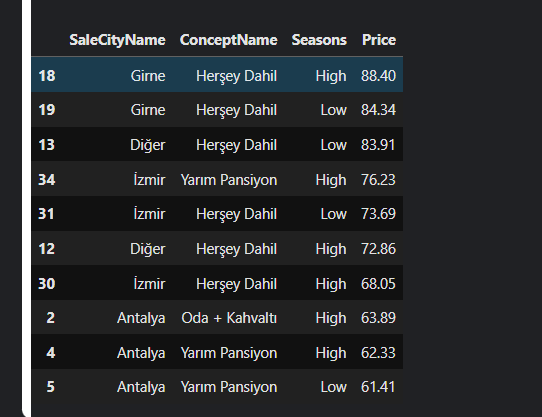

In [110]:
agg_df = agg_df.reset_index()


# sales_level_based Değişkeni ile Persona Tanımlama

Bu adımda, her bir müşteri segmentini daha net tanımlayabilmek için şehir, otel konsepti ve sezon bilgilerini birleştirerek yeni bir değişken oluşturdum: **sales_level_based**

Bu değişken sayesinde artık her müşteri tipi tek bir string ile temsil edilebiliyor.  

Bu yapı, özellikle segmentlere göre fiyat analizi veya sınıflandırma işlemleri için mükemmel bir temel oluşturuyor.

In [111]:
# Büyük harflerle ve alt çizgi ile birleştirerek yeni sütun oluşturma
agg_df["sales_level_based"] = (agg_df["SaleCityName"].str.upper() + "_" +
                               agg_df["ConceptName"].str.upper() + "_" +
                               agg_df["Seasons"].str.upper())

# Oluşan yeni yapı
agg_df[["SaleCityName", "ConceptName", "Seasons", "sales_level_based", "Price"]].head()

,SaleCityName,ConceptName,Seasons,sales_level_based,Price
0,Girne,Herşey Dahil,High,GIRNE_HERŞEY DAHIL_HIGH,88.40
1,Girne,Herşey Dahil,Low,GIRNE_HERŞEY DAHIL_LOW,84.34
2,Diğer,Herşey Dahil,Low,DIĞER_HERŞEY DAHIL_LOW,83.91
3,İzmir,Yarım Pansiyon,High,İZMIR_YARIM PANSIYON_HIGH,76.23
4,İzmir,Herşey Dahil,Low,İZMIR_HERŞEY DAHIL_LOW,73.69


Oluşturduğum `sales_level_based` değişkeni sayesinde artık her müşteri tipi;  
bulunduğu şehir, tercih ettiği konsept ve sezon bilgisiyle **benzersiz şekilde tanımlanabiliyor**.

Örneğin:

- `GİRNE_HERŞEY DAHİL_HIGH` → En pahalı segmentlerden biri (88.40 birim)
- `DİĞER_HERŞEY DAHİL_LOW` → Küçük şehirlerdeki Herşey Dahil kullanıcıları (83.91 birim)
- `İZMİR_YARIM PANSIYON_HIGH` → Orta seviye ama tatili planlı olan segment (76.23 birim)

Bu değişken, ileride fiyat tahmini, segment bazlı kampanya önerisi veya müşteri değer sınıflandırması gibi işlemler için **çok güçlü bir temel** oluşturdu.

Kısacası artık müşteriler:
- Sadece “nereli” değil
- Nasıl bir tatil planlıyor?
- Ne konsept tercih ediyor?
- Hangi sezonda harcıyor?

Bu soruların cevabına göre **tek satırlık etiketlerle** temsil edilebiliyorlar.

# Müşteri Segmentlerine Ayırma

Oluşturduğum her bir persona (`sales_level_based`), artık ödediği ortalama fiyata göre A’dan D’ye kadar segmentlere ayrıldı.

- A Segmenti → En yüksek harcayan müşteri grupları 
- D Segmenti → Düşük fiyatlı ama hacimsel olarak önemli olabilecek kitle

Bu segmentasyon, hangi müşteri tipine nasıl bir pazarlama veya fiyatlandırma stratejisi uygulanması gerektiği konusunda değerli içgörüler sunuyor.

In [112]:
# Her bir persona için ortalama fiyatı hesapla
persona_df = agg_df.groupby("sales_level_based").agg({
    "Price": "mean"
}).reset_index()

# Segmentleri oluştur: A en yüksek, D en düşük
persona_df["SEGMENT"] = pd.qcut(persona_df["Price"], 4, labels=["D", "C", "B", "A"])

# Segmentleri incele
persona_df.groupby("SEGMENT").agg({
    "Price": ["mean", "max", "sum", "count"]
})


/tmp/ipykernel_35/2067263403.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  persona_df.groupby("SEGMENT").agg({


Price                     
              mean    max     sum count
SEGMENT                                
D        33.223333  39.37  299.01     9
C        43.933333  49.86  395.40     9
B        56.998889  61.41  512.99     9
A        74.855556  88.40  673.70     9

Oluşturduğum `sales_level_based` personelarını, harcama tutarlarına göre 4 farklı segmente ayırdım:

| Segment | Ortalama Fiyat | Maksimum Fiyat | Toplam Gelir | Kayıt Sayısı |
|---------|-----------------|----------------|--------------|--------------|
| A       | 74.86           | 88.40          | 673.70       | 9            |
| B       | 57.00           | 61.41          | 512.99       | 9            |
| C       | 43.93           | 49.86          | 395.40       | 9            |
| D       | 33.22           | 39.37          | 299.01       | 9            |

**A Segmenti**, ortalama 74.86 birim harcayan en değerli müşteri grubum. Bu kitleye özel kampanya ve sadakat stratejileri geliştirilebilir.

**D Segmenti** ise daha düşük harcama yapan ama hacimsel olarak stratejik fırsatlar barındırabilecek bir grup.

Bu ayrım sayesinde artık her persona için:
- Hedefleme stratejisi belirleyebilirim.
- Gelir odaklı segmentleme yapılabilir.
- Pazarlama dili, teklif ve promosyonlar kişiselleştirilebilir hale geldi.


# Yeni Müşteri Profili için Segment ve Gelir Tahmini

Yeni gelen müşterinin tercihleri doğrultusunda oluşturduğum `sales_level_based` değerini, daha önce oluşturduğum segmentasyon tablosuyla eşleştirdim.

Bu tür tahminlemeler, hedefli kampanyalar ve müşteri değer yönetimi için kritik bir adımdır.

In [113]:
persona_df["sales_level_based"].unique()


array(['ANTALYA_HERŞEY DAHIL_HIGH', 'ANTALYA_HERŞEY DAHIL_LOW',
       'ANTALYA_ODA + KAHVALTI_HIGH', 'ANTALYA_ODA + KAHVALTI_LOW',
       'ANTALYA_YARIM PANSIYON_HIGH', 'ANTALYA_YARIM PANSIYON_LOW',
       'AYDIN_HERŞEY DAHIL_HIGH', 'AYDIN_HERŞEY DAHIL_LOW',
       'AYDIN_ODA + KAHVALTI_HIGH', 'AYDIN_ODA + KAHVALTI_LOW',
       'AYDIN_YARIM PANSIYON_HIGH', 'AYDIN_YARIM PANSIYON_LOW',
       'DIĞER_HERŞEY DAHIL_HIGH', 'DIĞER_HERŞEY DAHIL_LOW',
       'DIĞER_ODA + KAHVALTI_HIGH', 'DIĞER_ODA + KAHVALTI_LOW',
       'DIĞER_YARIM PANSIYON_HIGH', 'DIĞER_YARIM PANSIYON_LOW',
       'GIRNE_HERŞEY DAHIL_HIGH', 'GIRNE_HERŞEY DAHIL_LOW',
       'GIRNE_ODA + KAHVALTI_HIGH', 'GIRNE_ODA + KAHVALTI_LOW',
       'GIRNE_YARIM PANSIYON_HIGH', 'GIRNE_YARIM PANSIYON_LOW',
       'MUĞLA_HERŞEY DAHIL_HIGH', 'MUĞLA_HERŞEY DAHIL_LOW',
       'MUĞLA_ODA + KAHVALTI_HIGH', 'MUĞLA_ODA + KAHVALTI_LOW',
       'MUĞLA_YARIM PANSIYON_HIGH', 'MUĞLA_YARIM PANSIYON_LOW',
       'İZMIR_HERŞEY DAHIL_HIGH', 'İZMIR_HERŞEY 

In [120]:
new_user = "ANTALYA_HERŞEY DAHIL_HIGH"
persona_df[persona_df["sales_level_based"] == new_user]


,sales_level_based,Price,SEGMENT
0,ANTALYA_HERŞEY DAHIL_HIGH,59.99,B


Bu müşteri tipi; Antalya’da, her şey dahil konseptte ve yüksek sezonda tatil yapmayı tercih eden bir kullanıcı profiline karşılık geliyor.

Segment analizine göre bu kullanıcı grubu **B segmentinde** yer alıyor.  
Yani harcama potansiyeli yüksek, ancak A segmenti kadar premium değil.

Ortalama gelirleri: **59.99 birim**  
Bu kullanıcı tipi için özel fırsatlar, erken rezervasyon indirimleri veya premium hizmet yükseltmeleriyle kazanç artırılabilir.

Kısacası:  
**Karlı ama hâlâ geliştirilebilir bir müşteri grubu!**


In [122]:
new_user2 = "GIRNE_YARIM PANSIYON_LOW"
persona_df[persona_df["sales_level_based"] == new_user2]

,sales_level_based,Price,SEGMENT
23,GIRNE_YARIM PANSIYON_LOW,47.69,C


Bu kullanıcı profili; Girne’de, yarım pansiyon konseptiyle ve düşük sezonda tatil yapmayı tercih eden grubu temsil ediyor.

Segment olarak **C sınıfında** yer alıyorlar.  
Yani harcama düzeyi daha düşük, ancak potansiyel barındıran ve hacimsel olarak değerlendirilebilecek bir segment.

Ortalama harcama: **47.69 birim**  
Bu kullanıcıya sadakat programları, kampanyalar ya da fiyat-performans odaklı teklifler sunularak değer artırımı yapılabilir.

Kısacası:  
**Şu an düşük ama doğru stratejiyle sadık müşteriye dönüşebilecek bir profil.**


# Final Değerlendirme, Öğrendiklerim ve Geleceğe Dair

Bu proje sayesinde gerçek bir otel rezervasyon veri seti üzerinden uçtan uca bir müşteri segmentasyonu süreci deneyimledim. Özellikle:

- **Veri temizleme** ve **eksik değer yönetimi** konusunda daha sistematik çalışmayı,
- **Aykırı değerlerin etkilerini analiz etmeyi** ve hangi durumda ne tür müdahalelerin mantıklı olduğunu,
- **Yeni değişken üretmenin** analiz kalitesine olan katkısını,
- Ve son olarak, **segment bazlı analiz yaparak iş zekâsı açısından değerli çıkarımlar sunmayı** öğrendim.

Ayrıca sadece teknik değil, veri üzerinden düşünebilmeyi ve pazarlama tarafına yönelik yorumlar geliştirmeyi de pekiştirdim.

Bu proje benim için hem bir öğrenme süreci hem de portföyüme katabileceğim somut bir çıktıdır.

---

## Gelecekte Neler Yapılabilir?

- Segmentlere göre **müşteri profilleri daha da derinleştirilebilir** ve her segmentin satın alma alışkanlıkları incelenebilir.
- **Makine öğrenmesi modelleri** ile bu segmentlere otomatik sınıflandırma algoritmaları geliştirilebilir.
- Sezon, şehir ve konsept gibi faktörler dikkate alınarak **dinamik fiyatlandırma stratejileri** önerilebilir.
- Zaman serisi analizleriyle **rezervasyon eğilimleri** tahmin edilebilir.
- Daha geniş çaplı ve güncel verilerle **reklam hedeflemesi** gibi pazarlama stratejileri geliştirilebilir.

---

Bu süreçte hem teknik hem de analitik bakış açımı geliştirmeme katkı sağlayan Miuul ekibine ve kıymetli eğitmenimize içten teşekkür ederim.ım.
